# Event Risk

_Don’t worry about failure; you only have to be right once_ — Drew Houston

Concepts:
- Earnings surprises
- Poisson regression
- Generalized Linear Models
- Credit Losses


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, SignalsFrame, CRSP, IBES
from finds.readers import Alfred
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
#%matplotlib qt

In [26]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
ibes = IBES(sql, bd, verbose=VERBOSE)
store = Store(paths['scratch'])
LAST_DATE = CRSP_DATE

## Earnings misses

The quarterly earnings expectations from all the analysts that cover a company are averaged out to find the consensus analyst estimate. The number of analysts covering a particular company is largely dependent on the size of the company and the trading volume of its stock. Large, well-known companies tend to be covered by many analysts and the consensus is therefore derived from many opinions. A small, lesser-known company may be covered by only one or a few research analysts, and sometimes none at all.

If the company reports earnings below what research analysts were expecting, this would be considered an __earnings miss__.  If the company reports earnings greater than what analysts expected, it would be considered an __earnings beat__

1. Each quarter and stock in the universe: select latest IBES statistical period that is no later than than the fiscal quarter end date
2. SUE (standardized unexpected earnings) is computed as the fiscal quarter's reported earnings minus median Q1 estimate, scaled by stock price.


In [27]:
# retrieve ibes Q1 where forecast period <= fiscal date, and keep latest
df = ibes.get_linked(dataset='statsum',
                     fields=['fpedats', 'medest', 'actual'],
                     date_field='statpers',
                     where=" fpi = '6' AND statpers <= fpedats")


In [28]:
summ = df.dropna()\
         .sort_values(['permno', 'fpedats', 'statpers'])\
         .drop_duplicates(['permno', 'fpedats'], keep='last')
summ['rebaldate'] = bd.endmo(summ['fpedats'])
summ = summ.set_index(['permno', 'statpers'])

In [29]:
# retrieve ibes price
df = ibes.get_linked(dataset='actpsum',
                     fields=['price'],
                     date_field='statpers')


In [30]:
hist = df.dropna()\
         .sort_values(['permno', 'statpers'])\
         .drop_duplicates(['permno', 'statpers'], keep='last')
hist = hist.set_index(['permno', 'statpers'])

In [31]:
# calculate sue with ibes surprise and price
summ = summ.join(hist[['price']], how='inner')
summ['sue'] = (summ['actual'] - summ['medest']).div(summ['price'])

In [32]:
# define large earnings miss as 5% of price
START = 19841201
signals = SignalsFrame(summ.reset_index(drop=False))
rebaldates = bd.date_range(START, LAST_DATE-100, freq='quarterly')
label = 'sue'
out = []
for rebaldate in rebaldates:
    univ = crsp.get_universe(rebaldate)    # get this quarter's universe
    univ = univ[(abs(univ['prc']) >= 5.0) & (univ['decile'] < 9)]  # no small low-price
    signal = signals(label=label,
                     date=rebaldate,
                     start=bd.endqr(rebaldate, quarters=-1))\
                     .reindex(univ.index)\
                     .dropna()\
                     .reset_index()
    signal['rebaldate'] = rebaldate // 100
    signal['miss'] = signal['sue'] < -0.05   # large earnings misses
    out.append(signal.set_index('permno').join(univ['decile'], how='inner')\
               .reset_index())
out = pd.concat(out)

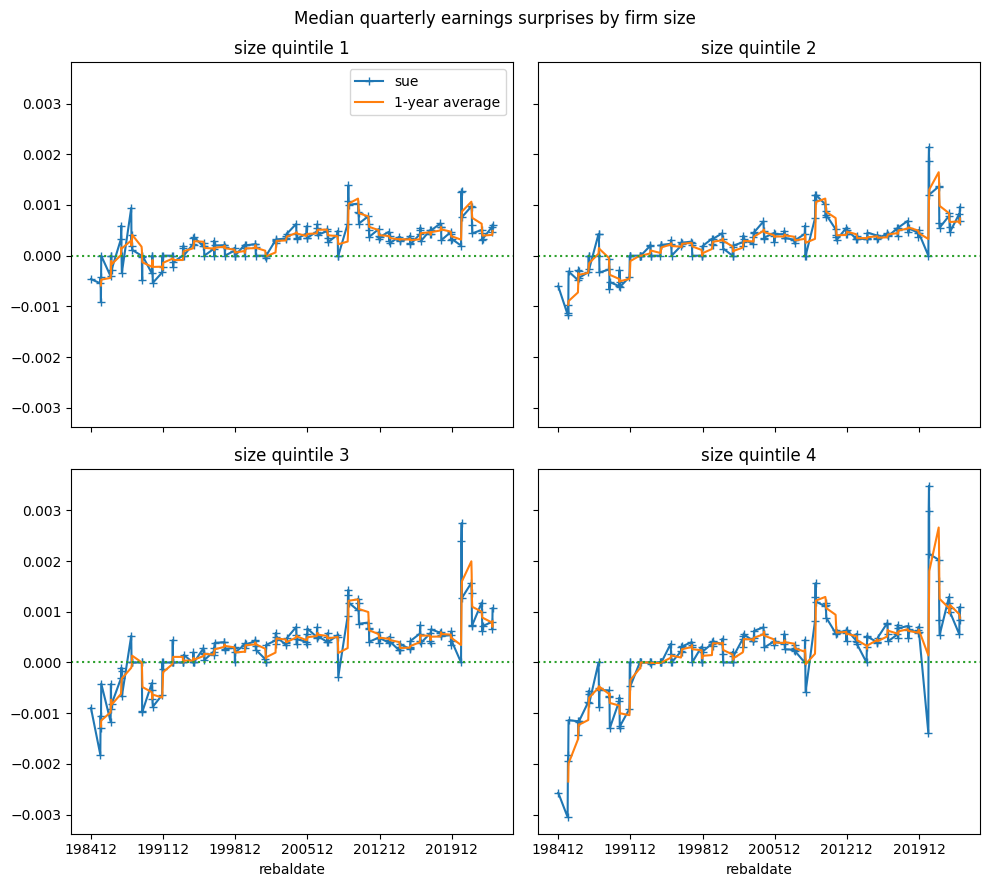

In [33]:
# median quarterly earnings surprise by firm size
fig, axes = plt.subplots(2, 2, figsize=(10, 9), sharex=True, sharey=True)
axes = axes.flatten()
for label, (ax, dec) in enumerate(zip(axes, [[1,2], [3,4], [5,6], [7,8]])):
    y = out[out['decile'].isin(dec)].groupby('rebaldate')['sue'].median()
    y.plot(ax=ax, marker='+', color="C0")
    y.rolling(4).mean().plot(ax=ax, color="C1")
    ax.set_title(f"size quintile {label+1}")
    if not label:
        ax.legend(['sue','1-year average'])
    ax.axhline(0, color='C2', ls=':')
    ax.set_xticks(y.index[::28])
    ax.minorticks_off()
plt.suptitle('Median quarterly earnings surprises by firm size')
plt.tight_layout()
plt.show()

Median quarterly earnings surprise tended to be negative prior to the mid-90's (especially smaller stocks) but turned generally positive after that.

In [34]:
# count number of stocks with large earnings misses
frac = out.groupby('rebaldate')['miss'].mean().rename('frac')
count = out.groupby('rebaldate')['miss'].sum().rename('count')
exposures = out['rebaldate'].value_counts().sort_index().rename('exposures')
Y = pd.concat([exposures, frac, count], axis=1)
Y.index = Y.index.astype(str)
print("Earnings misses")
Y

Earnings misses


,exposures,frac,count
rebaldate,,,
198412,1327,0.051997,69
198503,1302,0.038402,50
198506,1384,0.040462,56
198509,1384,0.033960,47
198512,1398,0.063662,89
...,...,...,...
202209,2080,0.009615,20
202212,2008,0.007968,16
202303,1910,0.005759,11


## Poisson regression

The Poisson distribution is typically used to model counts.  A Poisson regression models the expected response as a function of the covariances, specifically: $\log(E[Y | X]) = \beta X$, or equivalently $E[Y | X] = e^{\beta X}$

- Interpretation of coefficients: an increase in $X_i$ by one unit is associated with a change in $E[Y_i]$ by a factor of $\exp{\beta_i}$
- Under the Poisson model, $Var[Y_i] = E[Y_i]$
- No negative fitted values, because the Poisson model only allows for non-negative values.

Poisson regression may also be appropriate for _rate_ data, where the count of events divided by some measure of that unit's __exposure__.  When modelling the number of stocks with large earnings misses each quarter, the denominator of the rate would be the total number of stocks $N$ in the universe that quarter. The log of the total number is called the __offset__ variable, and enters on the right-hand side of the equation and a parameter estimate constrained to 1.

$$\log[\dfrac{E[Y|X]}{\mathrm{exposure}}] = \log{E[Y|X]} - \log(\mathrm{exposure}) = X\beta - \log(\mathrm{exposure})$$


### Generalized Linear Models

Linear and Poisson regression are generalized linear models (GLMs).

- Each approach models the mean of $Y_i$ as a function of the predictors, specifically: the transformed mean $E[Y_i]$ is a lienar function of the predictors.  That transformation is called a __link function__ $\nu$, which provides the relationship between the linear predictor and the mean of the distribution function. The inverse of the link function is called the __mean function__. The link functions for linear and Poisson regression are the identity $\nu(E[Y]) = E[Y]$ and log $\nu(E[Y]) = \log{E[Y]}$ respectively.

- Conditional on $X$, $Y$ belongs to some family of distributions, typically Gaussian for linear regression and Poisson for Poisson regression.  These distributions are members of the __exponential family__: other well-known members of this family are the Bernoulli, Multinomial, Exponential, Gamma, and the negative binomial distributions.

Any regression approach that models the response Y as coming from a particular
member of the exponential family, and then transforming the mean of the
response so that the transformed mean is a linear function of the predictors
is known as a generalized linear model. Poission regression models the response as coming from the Poisson distribution (with support 0, 1, 2...,), with its canonical link function being the log function $X\beta = \log{E[Y]}$, and the mean function being the exponential $E[Y] = e^{X\beta}$




In [39]:
# retrieve and transform economics series 
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)


In [40]:
X = pd.concat([alf(s, log=1, diff=1, freq='Q') for s in ['INDPRO', 'WILL5000IND']],
              axis=1)\
      .dropna()
X.index = (X.index // 100).astype(str)

In [41]:
# Run GLM regression with Poisson family and Log link
Z = Y.loc[Y.index > '199512'].join(X, how='inner')
Z['const'] = 1
glm = sm.GLM(exog=Z[['const'] + list(X.columns)],
             endog=Z['count'],
             family=sm.families.Poisson(link=sm.families.links.Log()),
             exposure=Z['exposures'])\
        .fit()
y_pred = glm.predict(exog=Z[['const'] + list(X.columns)],
                     exposure=Z['exposures']).rename('predicted')
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  111
Model:                            GLM   Df Residuals:                      108
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -431.05
Date:                Sat, 27 Apr 2024   Deviance:                       451.81
Time:                        17:00:51   Pearson chi2:                     523.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9695
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.3083      0.032   -163.880      

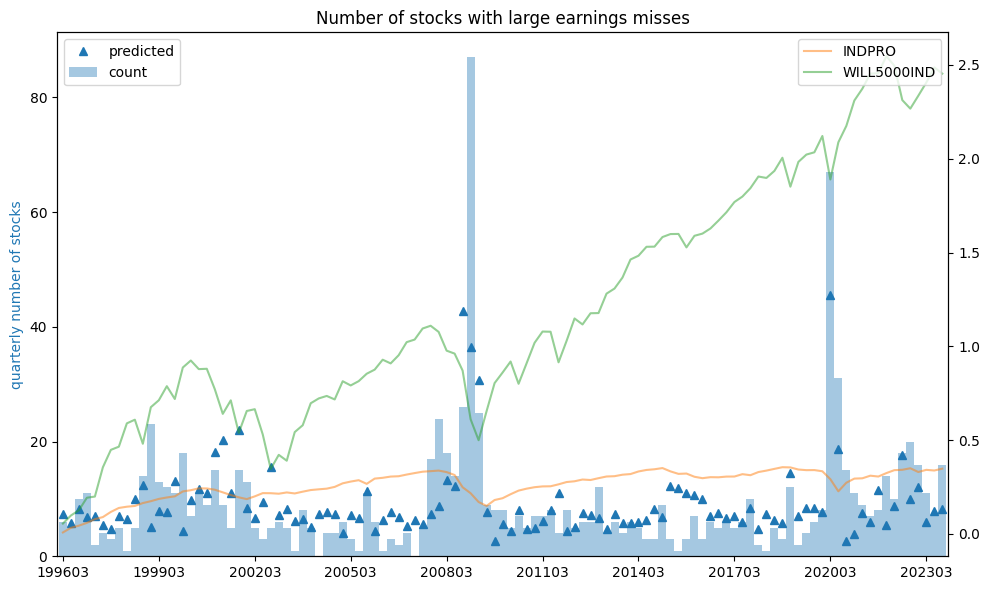

In [42]:
# Plot predicted and predictors
fig, ax = plt.subplots(figsize=(10, 6))
bx = ax.twinx()
Z['count'].plot(kind='bar', width=1.0, alpha=0.4, color="C0", ax=ax)
y_pred.plot(ls='', marker='^', color="C0", ax=ax)
ax.set_ylabel('quarterly number of stocks', color="C0")
Z['INDPRO'].cumsum().plot(color="C1", alpha=.5, ax=bx)
Z['WILL5000IND'].cumsum().plot(color="C2", alpha=.5, ax=bx)
ax.legend(loc='upper left')
bx.legend(loc='upper right')
ax.set_xticks(np.arange(0, len(Z), 12), Z.index[::12])
ax.set_title('Number of stocks with large earnings misses')
plt.tight_layout()

## Credit losses

Suppose a financial institution has a portfolio N loans, and:
- __default risk__ $p_i$ is the probability of default of the $i$ th loan
- __loss severity__ or loss given default $L_i$ is the portion of the $i$ th loan lost in the event of default.  This is often assumed known with certainty

Then Expected loss is the sum of Default Probability $\times$ Loss given default over all loans $= \sum_{i=1}^N p_i L_i$

The standard deviation of the expected loss on an individual loan, by applying the "Bernoulli shortcut" is $\sigma_i = \sqrt{p_i(1 - p_i)}L_i$.

The standard deviation of the loss of the portfolio depends on the correlation of defaults between loands $\sigma_P = \sqrt{\sum_i \sum_j \rho_{ij} \sigma_i \sigma_j}$. For tractability, the correlations may be simplified to be constant or determined by a (Gaussian) copula, though neither assumption suffices to model real markets.




## Actuarial losses

Actuaries use the __frequency-severity__ method for determining the expected number of claims that an insurer will receive during a given time period and how much the average claim will cost. Both are random (unlike the previous credit loss scenario where loss severity was assumed constant), and historical data may be used to model the expected number of claims and the expected cost of each claim, then multiplied together assuming they are independent.

https://sites.google.com/site/zoubin019/teaching/math-5639-actuarial-loss-models



### Claim frequency

TODO


### Claim severity

TODO

### Aggregate loss

TODO